In [150]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

In [151]:
def load_and_prepare_data(filepath):
    """Loads, sets index, and transposes the dataset."""
    print("  - Reading CSV file...")
    # Use delimiter=';' for semicolon-separated files. Change to ',' if needed.
    df = pd.read_csv(filepath, delimiter=';')
    print("  - Formatting DataFrame...")
    df = df.rename(columns={df.columns[0]: 'hour'})
    df = df.set_index('hour')
    df_transposed = df.transpose()
    print("  - Data loaded successfully.")
    return df_transposed

def segment_into_weeks(df_annual):
    """Segments annual profiles into weekly profiles."""
    num_years = df_annual.shape[0]
    hours_per_week = 168
    num_weeks_per_year = 52
    total_weeks = num_years * num_weeks_per_year
    required_hours = num_weeks_per_year * hours_per_week
    
    print(f"  - Reshaping {num_years} annual profiles into {total_weeks} weekly profiles...")
    weekly_data = df_annual.iloc[:, :required_hours].values.reshape(total_weeks, hours_per_week)
    print("  - Segmentation complete.")
    return pd.DataFrame(weekly_data)

def extract_features(df_weekly):
    """Calculates a feature vector for each week."""
    print("  - Calculating mean, std, max, and max_ramp for each week...")
    features = pd.DataFrame(index=df_weekly.index)
    features['mean'] = df_weekly.mean(axis=1)
    features['std'] = df_weekly.std(axis=1)
    features['max'] = df_weekly.max(axis=1)
    features['max_ramp'] = df_weekly.diff(axis=1).abs().max(axis=1)
    features.fillna(0, inplace=True)
    print("  - Feature extraction complete.")
    return features

In [152]:
start_time = time.time()
filepath = "WT.csv" # Make sure this filename matches your uploaded file

print("\nStep 1: Loading and preparing data...")
df_annual = load_and_prepare_data(filepath)

print("\nStep 2: Segmenting into weekly profiles...")
df_weekly = segment_into_weeks(df_annual)

print("\nStep 3: Extracting features for each week...")
features = extract_features(df_weekly)

print("\nStep 4: Scaling features...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
print("   - Scaling complete.")


Step 1: Loading and preparing data...
  - Reading CSV file...
  - Formatting DataFrame...
  - Data loaded successfully.

Step 2: Segmenting into weekly profiles...
  - Reshaping 100 annual profiles into 5200 weekly profiles...
  - Segmentation complete.

Step 3: Extracting features for each week...
  - Calculating mean, std, max, and max_ramp for each week...
  - Feature extraction complete.

Step 4: Scaling features...
   - Scaling complete.



Step 5: Analyzing for optimal number of clusters (k)...
  - Testing k=2...
  - Testing k=3...
  - Testing k=4...
  - Testing k=5...
  - Testing k=6...
  - Testing k=7...
  - Testing k=8...
  - Testing k=9...
  - Testing k=10...
  - Testing k=11...
  - Testing k=12...
  - Testing k=13...
  - Testing k=14...
  - Testing k=15...


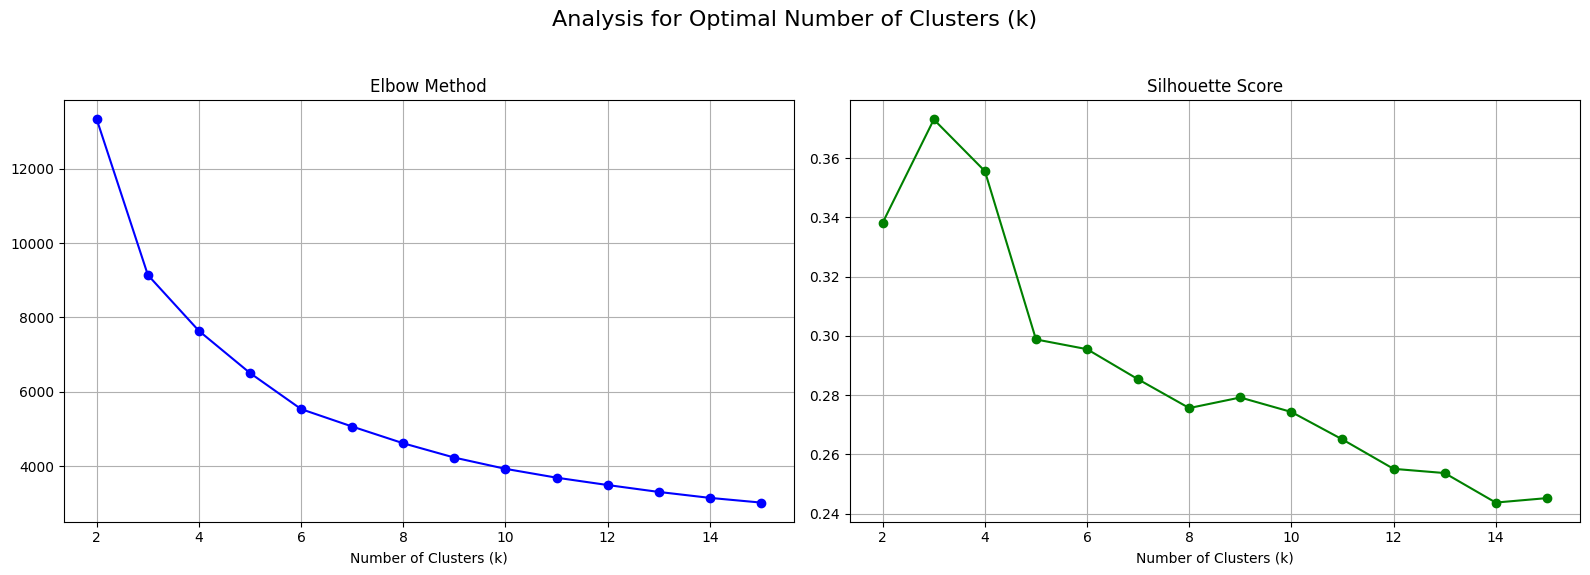


Generated plot to help choose the optimal k.


In [153]:
print("\nStep 5: Analyzing for optimal number of clusters (k)...")
inertia = []
silhouette_scores = []
K_range = range(2, 16)

for k in K_range:
    print(f"  - Testing k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plotting the results to find k
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Analysis for Optimal Number of Clusters (k)', fontsize=16)
ax1.plot(K_range, inertia, 'bo-'); ax1.set_title('Elbow Method'); ax1.set_xlabel('Number of Clusters (k)'); ax1.grid(True)
ax2.plot(K_range, silhouette_scores, 'go-'); ax2.set_title('Silhouette Score'); ax2.set_xlabel('Number of Clusters (k)'); ax2.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("\nGenerated plot to help choose the optimal k.")


Step 6: Performing final clustering with optimal k=5...
   - Clustering complete.

Step 7: Creating PCA visualization of clusters...


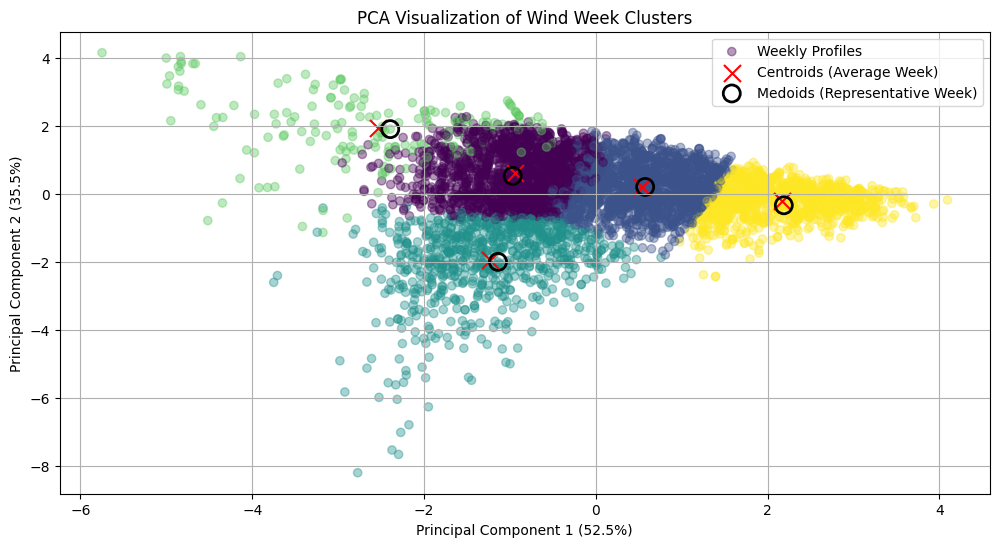

   - Generated PCA cluster visualization.


In [156]:
# --- CHOOSE YOUR 'k' HERE based on the plot from the previous cell ---
optimal_k = 5
# --------------------------------------------------------------------

print(f"\nStep 6: Performing final clustering with optimal k={optimal_k}...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(features_scaled)
centroids = kmeans_final.cluster_centers_
print("   - Clustering complete.")

# --- Perform PCA ---
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
centroids_pca = pca.transform(centroids)

# --- Find Medoids for plotting ---
medoid_indices = []
for i in range(optimal_k):
    cluster_indices = np.where(labels == i)[0]
    distances = np.linalg.norm(features_scaled[cluster_indices] - centroids[i], axis=1)
    medoid_index_in_cluster = np.argmin(distances)
    medoid_original_index = cluster_indices[medoid_index_in_cluster]
    medoid_indices.append(medoid_original_index)
medoids_pca = features_pca[medoid_indices]

# --- Create PCA Visualization with Explained Variance ---
print("\nStep 7: Creating PCA visualization of clusters...")
plt.figure(figsize=(12, 6))

# Get the explained variance percentages
explained_variance = pca.explained_variance_ratio_

# Plot all the weekly data points
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.4, label='Weekly Profiles')

# Plot the centroids (the average)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=150, c='red', marker='x', label='Centroids (Average Week)')

# Plot the medoids (the chosen representative real week)
plt.scatter(medoids_pca[:, 0], medoids_pca[:, 1], s=150, facecolors='none', edgecolors='black', linewidth=2, label='Medoids (Representative Week)')

plt.title('PCA Visualization of Wind Week Clusters')
# --- NEW: Add percentages to axis labels ---
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.1%})')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.1%})')
plt.legend()
plt.grid(True)
plt.show()
print("   - Generated PCA cluster visualization.")


Step 8: Selecting, plotting, and saving the final representative profiles...
  - Cluster 1: The most representative week is Week #883 from the original dataset.
  - Cluster 2: The most representative week is Week #1441 from the original dataset.
  - Cluster 3: The most representative week is Week #1313 from the original dataset.
  - Cluster 4: The most representative week is Week #4389 from the original dataset.
  - Cluster 5: The most representative week is Week #4969 from the original dataset.
   - Generated 'representative_profiles.png'.
   - Saved representative profiles to 'representative_profiles.csv'.

--- Analysis Complete ---
Total execution time: 158.42 seconds.


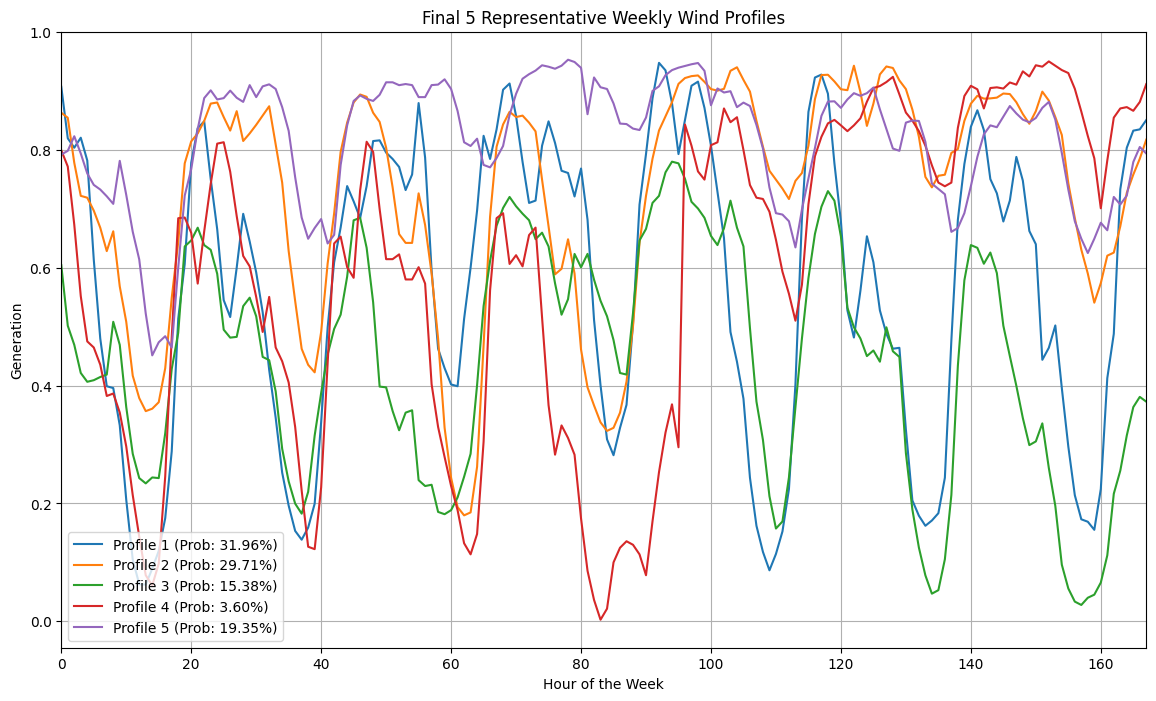

In [157]:
print("\nStep 8: Selecting, plotting, and saving the final representative profiles...")
representative_profiles = []
for i, medoid_index in enumerate(medoid_indices):
    print(f"  - Cluster {i+1}: The most representative week is Week #{medoid_index} from the original dataset.")
    profile_to_append = df_weekly.iloc[medoid_index]
    representative_profiles.append(profile_to_append)

plt.figure(figsize=(14, 8))
for i, profile in enumerate(representative_profiles):
    probability = (labels == i).sum() / len(labels)
    plt.plot(profile.index, profile.values, label=f'Profile {i+1} (Prob: {probability:.2%})')
plt.title(f'Final {optimal_k} Representative Weekly Wind Profiles'); plt.xlabel('Hour of the Week'); plt.ylabel('Generation');
plt.legend(); plt.grid(True); plt.xlim(0, 167);
plt.savefig("representative_profiles.png")
print("   - Generated 'representative_profiles.png'.")

pd.DataFrame(representative_profiles).to_csv("representative_profiles.csv")
print("   - Saved representative profiles to 'representative_profiles.csv'.")

end_time = time.time()
print(f"\n--- Analysis Complete ---")
print(f"Total execution time: {end_time - start_time:.2f} seconds.")